In [1]:
import numpy as np
from CIR import get_CIR
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from simulation import Simulation
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
device = 'cuda'

In [3]:
# I am setting v_0=b, so we start the process in its long-term mean

alpha = 0.6
b = 0.04
sigma = 0.14
v_0 = 0.04
years = 30
gamma = 0.4

sim = Simulation(alpha, b, sigma, v_0, years, gamma = gamma, seed=True)

In [4]:
arrival_times = np.array([i*380 for i in range(years)])         #Da mettere poi 380 e years
print('Simulation horizon: ', sim.TotPoints)
print('Arrival times: ', arrival_times)

Simulation horizon:  10950
Arrival times:  [    0   380   760  1140  1520  1900  2280  2660  3040  3420  3800  4180
  4560  4940  5320  5700  6080  6460  6840  7220  7600  7980  8360  8740
  9120  9500  9880 10260 10640 11020]


In [5]:
def prepare_contract(arrival_time, sim, t):
    contract = np.zeros((6))
    contract[0] = int(arrival_time + 364 - t)/365                                 #T-t/365 ()   
    contract[1] = +1 #np.random.choice ([-1,1])                                   #delta
    contract[2] = sim.Price(int(arrival_time), int(arrival_time + 364))           #p(t_0, T)    
    contract[3] = sim.Price(int(t), int(arrival_time + 364))                      #p(t, T)      
    contract[4] = np.prod(1+(sim.CIRProcess[0:arrival_time+1]*1/365))             #B_t_0.       
    contract[5] = sim.MarkToMarketPrice(+1, arrival_time, t, arrival_time + 364)  #V(t) 
    return contract
def get_arrival_time(t):

    return (t//380)*380

In [6]:
X = []
#I need an auxiliary array that contains (t_0, T, delta) so that i can use `Simulation` methods to compute the targets M_t
X_for_simulation = []

for i in range(years):
    
    for t in range((i*380), np.minimum((i*380) + 364 +1, sim.TotPoints)):
        
        arrival_time = get_arrival_time(t)
        contract = prepare_contract(arrival_time, sim, t)
        
        X.append(contract)
        X_for_simulation.append(np.array([arrival_time, arrival_time + 364, +1]))
    
    for i in range(np.minimum((i*380) + 364, sim.TotPoints), np.minimum(((i+1) * 380) - 1, sim.TotPoints)):
        
        X.append(np.zeros((6)))
        X_for_simulation.append(np.zeros((3)))

/u/mcitterio/NodeRegression/simulation.py:165: RuntimeWarning: divide by zero encountered in divide
  return np.where(condition, 0, (tau>0)*(-1 / tau) * ((price(t_0, T) - 1) / price(t_0, T)) )
/u/mcitterio/NodeRegression/simulation.py:165: RuntimeWarning: invalid value encountered in multiply
  return np.where(condition, 0, (tau>0)*(-1 / tau) * ((price(t_0, T) - 1) / price(t_0, T)) )


In [7]:
print('Len X: ', len(X))
print('Len auxiliary X: ', len(X_for_simulation))

Len X:  10950
Len auxiliary X:  10950


In [8]:
#Let's put them into tensors
X = torch.tensor(np.stack(X))
X_for_simulation = torch.tensor(np.stack(X_for_simulation))

In [9]:
#Define targets
targets_vt = np.zeros((len(X)))   #Contains V(t) for t\in [0, sim.totPoints -1]
#targets_vt_1 = np.zeros((len(X)-1)) #Contains V(t+1) for t\in [0, sim.totPoints]
#targets_mt_1 = np.zeros((len(X)-1)) #Contains M(t+1) for t\in [0, sim.totPoints]

In [10]:
#Fill targets
for i in range(years):
    
    start_index = (i * 380)
    end_index = np.minimum((i*380) + 364 + 1, sim.TotPoints)
    
    vt = np.asarray([sim.MarkToMarketPrice(+1, int(X_for_simulation[t,0]), t, int(X_for_simulation[t,1])) for t in range((i * 380), np.minimum((i*380) + 364 +1, sim.TotPoints))])
    #vt1 = np.asarray([sim.MarkToMarketPrice(+1, int(X_for_simulation[t+1,0]), t+1, int(X_for_simulation[t+1,1])) for t in range((i * 380), np.minimum((i*380) + 364 +1, sim.TotPoints-1))])
    #mt1 = np.asarray([sim.GetInstantContractMarginValue(t+1, X_for_simulation[t+1]) for t in range((i * 380), np.minimum((i*380) + 364 +1 , sim.TotPoints-1))])

    #targets_mt_1[ start_index : end_index] = mt1
    targets_vt[ start_index : end_index] = vt
    #targets_vt_1[ start_index : end_index] = vt1


In [11]:
len(targets_vt)

10950

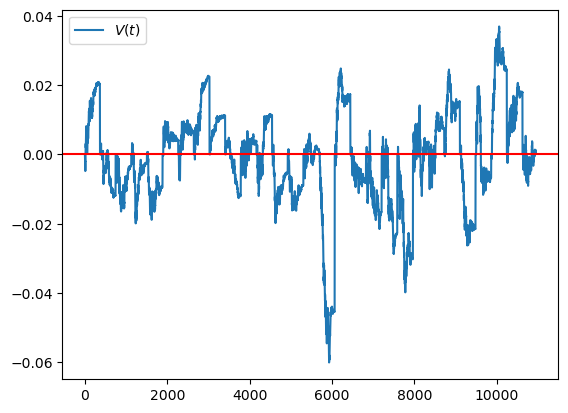

In [12]:
plt.plot(targets_vt, label='$V(t)$')
plt.legend()
plt.axhline(0, c='red')
plt.grid()
plt.show()

In [13]:
#X will contain X(t) for t \in [0, sim.totPoints]
X_data = X
training_index = int(0.8 * X_data.shape[0])
print('Features shape: ', X_data.shape)

Features shape:  torch.Size([10950, 6])


In [14]:
#For scaling the targets
def scale_target(target, training_index):
    """
    Scales and reshape the tensor so that it has shape [sim.totPoints -1 , 1]
    """

    target = torch.tensor(target).reshape(-1,1)
    
    scaler = MinMaxScaler()
    scaler.fit(target[:training_index].cpu())
    scaler.scale_ /= 1.25

    target = scaler.transform(target.cpu())
    return torch.tensor(target).to(torch.float32).to(device)

In [15]:
#Scale the targets
targets_vt = scale_target(targets_vt, training_index)
#targets_vt_1 = scale_target(targets_vt_1, training_index)
#targets_mt_1 = scale_target(targets_mt_1, training_index)

In [16]:
#Define interest rate process and accrued process
CIRProcess = sim.CIRProcess
B_t = np.asarray([np.prod(1+(CIRProcess[0:t]*1/365)) for t in range(1,len(CIRProcess)+1)])
B_t = torch.tensor(B_t.reshape(-1,1)).to(torch.float32).to(device)
CIRProcess = torch.tensor(sim.CIRProcess.reshape(-1,1)).to(torch.float32).to(device)

In [17]:
#Concat in the feauture matrix
X_data = X_data.to(torch.float32).to(device)
X_data = torch.cat([X_data, B_t], axis = 1).to(device)
print('X_data.shape: ', X_data.shape)

X_data.shape:  torch.Size([10950, 7])


In [18]:
# Separate training and test set 0.8 - 0.2
train, test = X_data[:training_index, :], X_data[training_index:, :]
CIR_train, CIR_test = CIRProcess[:training_index], CIRProcess[training_index:]

#Targets training and test set
targets_vt_train, targets_vt_test = targets_vt[:training_index], targets_vt[training_index:]
#targets_vt_1_train, targets_vt_1_test = targets_vt_1[:training_index], targets_vt_1[training_index:]
#targets_mt_1_train, targets_mt_1_test = targets_mt_1[:training_index], targets_mt_1[training_index:]

In [20]:
def create_windows(features, r, targets, lookback):
    """
    Windows the dataset
    """

    n_samples = features.shape[0] - lookback

    X_data = torch.zeros(n_samples, lookback, features.shape[1])
    y_data = torch.zeros(n_samples, 1)
    r_data = torch.zeros(n_samples, 1)

    for i_sample in range(n_samples):

        X_data[i_sample, :] = features[i_sample : i_sample + lookback]   #it takes data in [i_sample, i_sample+lookback)
        y_data[i_sample, 0] = targets[i_sample + lookback]               #it takes [i_sample + lookback] which is +1 time shifted w.r.t. the feature set
        r_data[i_sample, 0] = r[i_sample + lookback]
    
    return X_data.to(torch.float32).to(device), y_data.to(torch.float32).to(device), r_data.to(torch.float32).to(device)
    

In [22]:
lookback = 10

#Windowing slicing - TRAIN
X_train, y_vt_train, r_train = create_windows(train, CIR_train, targets_vt_train, lookback=lookback)

#_, y_vt_1_train, _ = create_dataset_all_sequence(train, CIR_train, targets_vt_1_train, lookback=lookback)
#_, y_mt_1_train, _ = create_dataset_all_sequence(train, CIR_train, targets_mt_1_train, lookback=lookback)

#Windowing slicing - TEST
X_test, y_vt_test, r_test = create_windows(test, CIR_test, targets_vt_test, lookback=lookback)

#_, y_vt_1_test, _ = create_dataset_all_sequence(test, CIR_test, targets_vt_1_test, lookback=lookback)
#_, y_mt_1_test, _ = create_dataset_all_sequence(test, CIR_test, targets_mt_1_test, lookback=lookback)

#Print out some shapes for User friendlyness
print(f'Training features: {X_train.shape}, test features: {X_test.shape}')
print('\n')
print(f'Training V(t): {y_vt_train.shape}, test V(t): {y_vt_test.shape}')
print(f'Training r(t): {r_train.shape}, test r(t+1): {r_test.shape}')

Training features: torch.Size([8750, 10, 7]), test features: torch.Size([2180, 10, 7])


Training V(t): torch.Size([8750, 1]), test V(t): torch.Size([2180, 1])
Training r(t+1): torch.Size([8750, 1]), test r(t+1): torch.Size([2180, 1])


In [23]:
#The actual target we are going to compute the loss on:
y_train = y_vt_train
y_test = y_vt_test

In [24]:
#Build the pytorch datasets and dataloaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device), r_train.to(device))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device), r_test.to(device))

loader = DataLoader(train_dataset, shuffle=True, batch_size=500)
loader_test = DataLoader(test_dataset, shuffle=True, batch_size = 500)

In [25]:
#define the model
class model(nn.Module):

    def __init__(self):
        super(model, self).__init__()

        input_size = 7
        lstm_hidden_size = 15
        lstm_n_layers = 1
        regressor_hidden_size = 256
        self.name=regressor_hidden_size

        self.lstm = torch.nn.LSTM(input_size=input_size, 
                             hidden_size=lstm_hidden_size, 
                             num_layers=lstm_n_layers)
        
        #Il +1 è perchè facciamo il concat con il reference interest rate
        self.regressor = nn.Sequential(nn.Linear(lstm_hidden_size+1, regressor_hidden_size),
                                       nn.ReLU(),
                                       nn.Linear(regressor_hidden_size, 1))
        
        self.reset_parameters()

    def forward(self, x, r):

        lstm_hidden, _ = self.lstm(x)
        return self.regressor(torch.squeeze(torch.cat([lstm_hidden[:,-1,:], r],dim=1)))
    
    def reset_parameters(self):

        self.lstm.reset_parameters()
        for layer in [self.regressor]:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

In [26]:
#Let's get towards the training:

lr = 1e-2                          #Learning rate
criterion = nn.MSELoss()           #Loss function

#Define the model
mymodel = model().to(device)    

#optimizer & scheduler
optimizer = torch.optim.Adam(mymodel.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100*i for i in range(100)], gamma=0.97)

n_epochs = 20000                   #Number of epochs

#Early stopping parameters
patience = 30                      #Number of consecutive epochs to wait for improvement

In [27]:
#print the model
mymodel

model(
  (lstm): LSTM(7, 15)
  (regressor): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [28]:
def do_epoch(loader, model, criterion, optimizer, training=True):
    """
    Trains the model over the batches for an epoch
    """
    
    #Instantiate a temp variable that tracks the average loss for the batches
    temp_loss = 0

    #Loop over data batches
    for X_batch, y_batch, r_batch in loader:

        #.forward() method of the model
        y_pred = model(X_batch, r_batch)

        #Compute the loss
        loss = criterion(y_pred, y_batch)

        #If we are actually training the model instead of permorming validation
        if training:

            #Backpropagation
            loss.backward()
    
            #Optimizer step
            optimizer.step() 
            optimizer.zero_grad()

        #Track the batch loss
        temp_loss += loss.item()

    #Take the average loss over the batches
    return temp_loss / len(loader)

In [29]:
#Early stopping class
class EarlyStopping:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
        self.best_score = 10
        self.early_stop = False

    def __call__(self, val_loss, model):
    
        if val_loss > self.best_score:

            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:

            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), f'temp_state_dict{mymodel.name}.pt')

In [30]:
#Define two lists to store training record
training_loss = []
validation_loss = []
lrs = []

#Define a tqdm loop to get a nice progress bar
loop = tqdm(range(n_epochs))

#Define an early stopping object
early_stopping = EarlyStopping(patience)

for epoch in loop:

    #Set model in training mode
    mymodel.train()

    #Perform an epoch of training
    train_loss = do_epoch(loader, mymodel, criterion, optimizer)

    #Scheduler step
    scheduler.step()

    #Track the average over the batches
    training_loss.append(train_loss)

    
    #Validation every 50 epochs
    if epoch % 50 ==0:

        with torch.no_grad():
            #Set the model in eval mod
            mymodel.eval()

            test_loss = do_epoch(loader_test, mymodel, criterion, optimizer, training=False)

            #Track the average loss over the batches
            validation_loss.append(test_loss)

        #Check early stopping
        early_stopping(validation_loss[-1], mymodel)
        if early_stopping.early_stop:

            #Load the best set of parameters
            mymodel.load_state_dict(torch.load(f'temp_state_dict{mymodel.name}.pt'))
            print(f"Early stopping at epoch {epoch}.")
            break

    lrs.append(optimizer.param_groups[0]["lr"])
            
    #Give informations in the loop
    loop.set_postfix(loss = train_loss, val_loss = test_loss, best_val_loss = early_stopping.best_score, counter=early_stopping.counter, lr= lrs[-1])


  0%|          | 0/20000 [00:00<?, ?it/s]

Early stopping at epoch 2250.


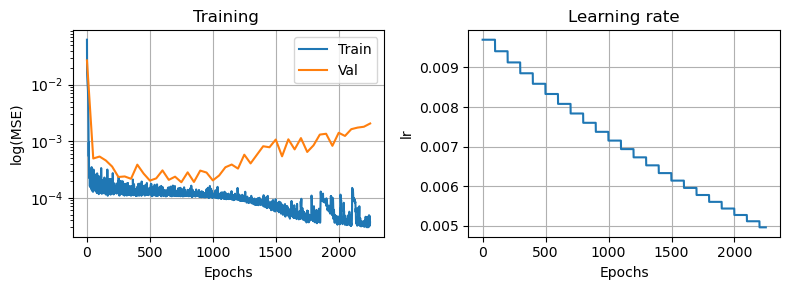

In [65]:
#Plot training record & learning rate schedule

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(training_loss, label='Train')
val_epochs= np.linspace(0, len(training_loss), num=len(validation_loss))
plt.plot(val_epochs, validation_loss, label='Val')
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('log(MSE)')
plt.title('Training ')

plt.subplot(1,2,2)
plt.plot(lrs)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.title('Learning rate')

plt.tight_layout()
plt.show()

In [34]:
#Makes the predictions
def predictions(dataset, model):

    dataloader = DataLoader(dataset, shuffle=False, batch_size=1)

    y_preds = torch.zeros(len(dataloader))
    y_trues = torch.zeros(len(dataloader))
    for i_sample, (X, y, r) in enumerate(dataloader):
        with torch.no_grad():
            y_preds[i_sample] = model(X,r).cpu()
            y_trues[i_sample] = y.cpu()
            
    return y_trues.numpy(), y_preds.numpy()

In [35]:
#Get the predictions
train_labels, train_preds = predictions(train_dataset, mymodel)
test_labels, test_predictions = predictions(test_dataset, mymodel)

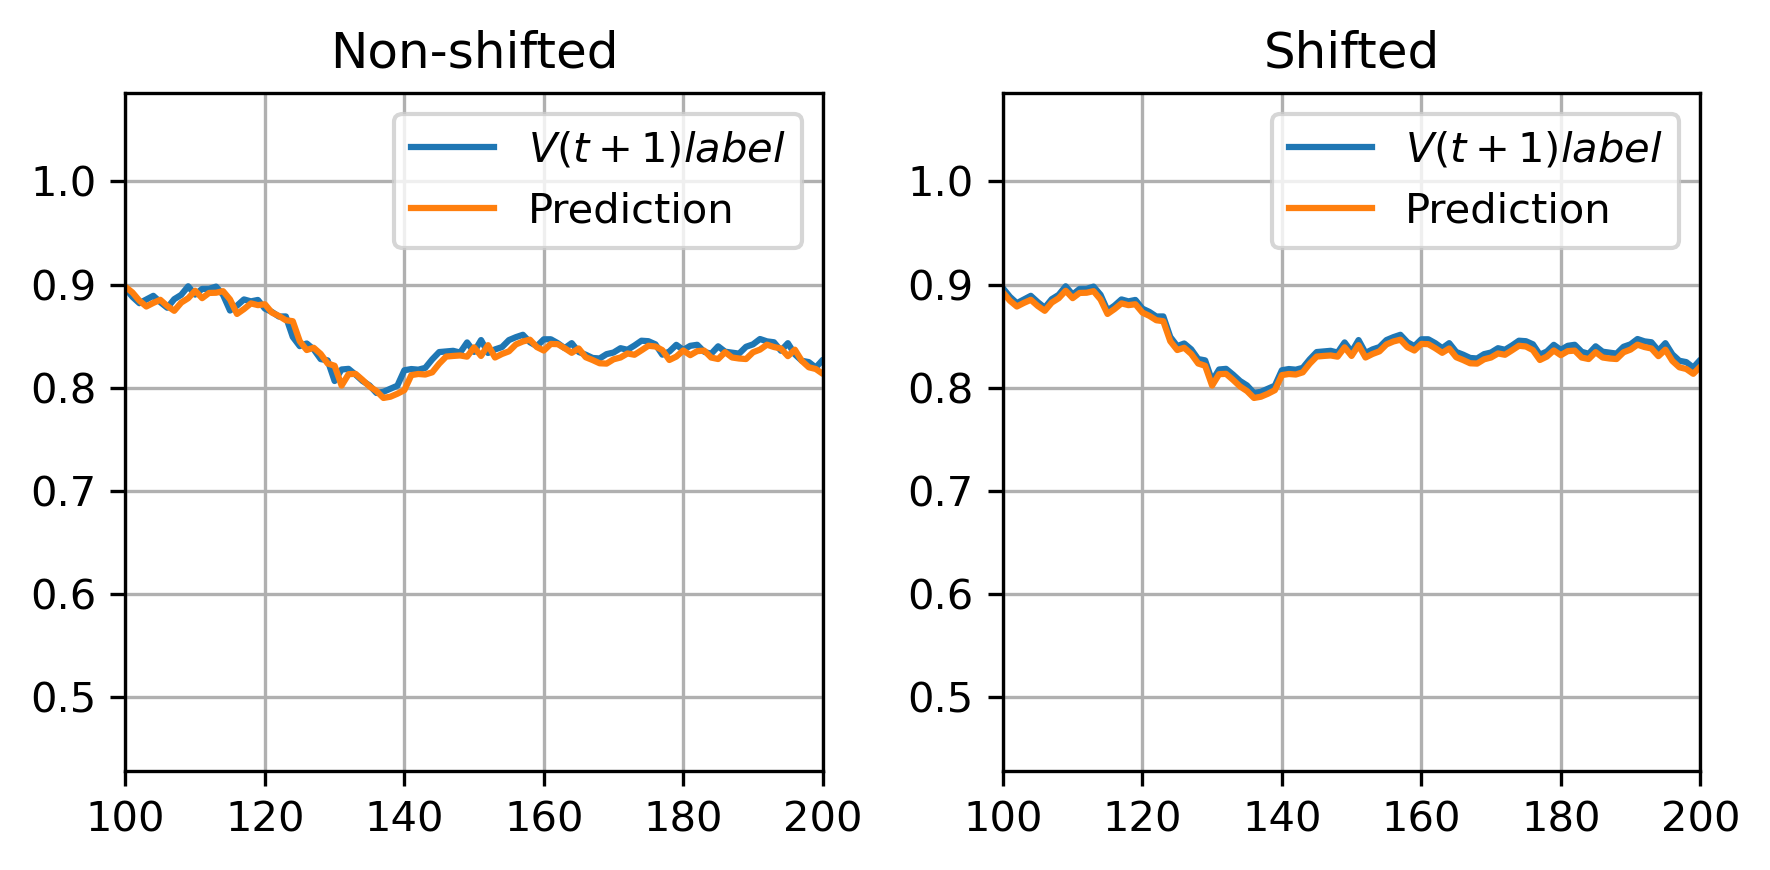

In [57]:
#Plot predictions
plt.figure(figsize=(6,3), dpi=300)

plt.subplot(1,2,1)
plt.plot(test_labels, label='$V(t+1) label$')
plt.plot(test_predictions, label='Prediction')
plt.xlim(100,200)
plt.grid()
plt.legend()
plt.title('Non-shifted')

plt.subplot(1,2,2)
plt.plot(test_labels[:-1], label='$V(t+1) label$')
plt.plot(test_predictions[1:], label='Prediction')
plt.xlim(100,200)
plt.grid()
plt.legend()
plt.title('Shifted')

plt.tight_layout()
plt.show()

If I try to compute the loss between targets and labels i find, as expected, the same best val loss I observed during training:

In [58]:
criterion(torch.tensor(test_labels), torch.tensor(test_predictions))

tensor(0.0002)

However, If i shift the arrays I find a better loss

In [59]:
criterion(torch.tensor(test_labels[:-1]), torch.tensor(test_predictions[1:]))

tensor(9.4611e-05)